**ETL and Preprocessing from Chapter 2 of GNNs in Action.**

This notebook will start with raw data files and:
1. Create a graph in Edge List and Adjacency List format, saved into text files.
2. Load this graph into NetworkX using the adjacency list.
3. Use NetworkX for light EDA and visualization.
4. Use Pytorch Geometric (PyG) to pre-process the graph into a PyG dataset that can be used for training.




I. Get raw data (json and csv files) from shared google drive

In [1]:
!gdown --id 1xITW9zRpkzi0tuebj2e9GIFa5jvokbqF # download sample json file
!gdown --id 1gL63dwzlfjSfBHl8b-JRjBnjyRBhbHAZ # download sample csv file



/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xITW9zRpkzi0tuebj2e9GIFa5jvokbqF
To: /content/relationships_hashed.json
100% 964k/964k [00:00<00:00, 49.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gL63dwzlfjSfBHl8b-JRjBnjyRBhbHAZ
To: /content/node_attributes_hashed.csv
100% 155k/155k [00:00<00:00, 77.4MB/s]


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import count
import json
from multiprocessing import Pool
import matplotlib.pyplot as plt

II. Load data files into memory.

First, turn the csv file of node properties into a Panda's Dataframe, then into a dictionary.

In [3]:
node_attr = pd.read_csv('/content/node_attributes_hashed.csv', encoding = "ISO-8859-1")
node_attr = node_attr[['hashedid','company_type','position_type']]
node_attr.info()

node_attr = node_attr.set_index('hashedid')
# node_attr.tail()
attribute_dict = node_attr.to_dict(orient='index')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hashedid       1947 non-null   object
 1   company_type   1947 non-null   object
 2   position_type  1947 non-null   object
dtypes: object(3)
memory usage: 45.8+ KB


In [4]:
# attribute_dict

Read JSON File.

In [5]:
# Opening JSON file
candidate_link_file = open('relationships_hashed.json')

# returns JSON object as a dictionary
adjacencies_from_candidate_referrals = json.load(candidate_link_file)

# Closing file
candidate_link_file.close()

In [6]:
len(set(adjacencies_from_candidate_referrals.keys()))

1855

III. Create Edge List and Adjacency List.

In [7]:
def create_adjacency_list(data_dict, suffix=''):
    '''
    This function is meant to illustrate the transformation of raw
    data into an adjacency list. It was created for the social graph
    use case.

    INPUT: a. a dictionary of candidate referrals where they keys
              are members who have referred other candidates, and
              the values are lists of the people who where referred.
           b. a suffix to append to the file name

    OUTPUT: i. An encoded adjacency list in a txt file.
            ii. A list of the node IDs found.
    '''
    list_of_nodes = []

    for source_node in list(data_dict.keys()):

        if source_node not in list_of_nodes:
            list_of_nodes.append(source_node)

        for y in data_dict[source_node]:

            if source_node not in list_of_nodes:
                list_of_nodes.append(y)
            if y not in data_dict.keys():
                data_dict[y]=[source_node]

            else:
                if source_node not in data_dict[y]:
                    data_dict[y].append(source_node)

                else: continue


    g= open("adjacency_list_{}.txt".format(suffix),"w+")

    for source_node in list(data_dict.keys()):
        dt = ' '.join(data_dict[source_node])
        # print("{} {}".format(source_node, dt))
        g.write("{} {} \n".format(source_node, dt))

    g.close

    print(len(list_of_nodes))
    return list_of_nodes, data_dict

In [8]:
list_of_nodes_adj, candidate_dict = create_adjacency_list(adjacencies_from_candidate_referrals, 'candidates')

1855


In [9]:
# list_of_nodes_adj

In [10]:
graph_from_adj = nx.read_adjlist('adjacency_list_candidates.txt')
graph_from_adj.number_of_edges(), graph_from_adj.number_of_nodes()

(12239, 1933)

In [11]:
# create edge list

def create_edge_list(data_dict, suffix=''):
    '''
    This function is meant to illustrate the transformation of raw
    data into an edge list. It was created for the social graph
    use case.

    INPUT: a. a dictionary of candidate referrals where they keys
              are members who have referred other candiates, and
              the values are lists of the people who where referred.
           b. a suffix to append to the file name

    OUTPUT: i. An edge adjacency list in a txt file.
            ii. Lists of the node IDs found and the edges generated.
    '''


    edge_list_file = open("edge_list_{}.txt".format(suffix),"w+")
    list_of_edges = []
    list_of_nodes_all = []

    for source_node in list(data_dict.keys()):
        if source_node not in list_of_nodes_all:
            list_of_nodes_all.append(source_node)
        list_of_connects = data_dict[source_node]

        for destination_node in list_of_connects:
            if destination_node not in list_of_nodes_all:
                list_of_nodes_all.append(destination_node)

            if {source_node, destination_node} not in list_of_edges:
                print("{} {}".format(source_node, destination_node))
                edge_list_file.write("{} {} \n".format(source_node, destination_node))
                list_of_edges.append({source_node, destination_node})

            else: continue

    edge_list_file.close
    return list_of_edges, list_of_nodes_all

In [12]:
list_of_edges, list_of_nodes = create_edge_list(adjacencies_from_candidate_referrals, 'candidates')

Streaming output truncated to the last 5000 lines.
fa7e15a04d0b253782c83138d3fe695ff5a5673b f52831826ec6b6d03841777559a88a8e3addc9c1
fa7e15a04d0b253782c83138d3fe695ff5a5673b 86916ed9cc4a5d6b54621f444c622f363bbaecb8
fa7e15a04d0b253782c83138d3fe695ff5a5673b 2f1f7ef698394da7d9c3246dc8c249c2f8bcfc1d
fa7e15a04d0b253782c83138d3fe695ff5a5673b e034c9932ddaa2a62254e90a97ffc848df17639c
7cad933b8ae0e2b6afe397d9201b07b4358e14ab e3db1b22766197115acbea239c5afb31643036ed
7cad933b8ae0e2b6afe397d9201b07b4358e14ab a31695c6d4a826682749e7841168807b1904183b
7cad933b8ae0e2b6afe397d9201b07b4358e14ab f52831826ec6b6d03841777559a88a8e3addc9c1
7cad933b8ae0e2b6afe397d9201b07b4358e14ab cf781286bfa5c48b05cd5afb14ca076f811386e8
7cad933b8ae0e2b6afe397d9201b07b4358e14ab 86916ed9cc4a5d6b54621f444c622f363bbaecb8
7cad933b8ae0e2b6afe397d9201b07b4358e14ab ed34ac4c1248e36d0a717b9a24bb534531767415
7cad933b8ae0e2b6afe397d9201b07b4358e14ab 2f1f7ef698394da7d9c3246dc8c249c2f8bcfc1d
7cad933b8ae0e2b6afe397d9201b07b4358e14ab e034c9

In [13]:
len(list_of_edges), len(list_of_nodes), len(list_of_nodes_adj)

(12239, 1933, 1855)

In [14]:
graph_from_edge_list = nx.read_edgelist('edge_list_candidates.txt')
graph_from_edge_list.number_of_edges(), graph_from_edge_list.number_of_nodes()

(12239, 1727)

IV. Data Exploration
In this section, we:


*   load our adjacency list into NetworkX
*   Establish the number of nodes, edges and connected components
*   Select the large connected component for some visualizations and summary statistics



In [15]:
social_graph = nx.read_edgelist('edge_list_candidates.txt')
nx.set_node_attributes(social_graph, attribute_dict)
print(social_graph.number_of_nodes(), social_graph.number_of_edges())
# number of nodes and edges

1727 12239


In [16]:
social_graph = nx.read_adjlist('adjacency_list_candidates.txt')
nx.set_node_attributes(social_graph, attribute_dict)
print(social_graph.number_of_nodes(), social_graph.number_of_edges())

1933 12239


In [17]:
len(list((c for c in nx.connected_components(social_graph))))
# There are 219 connected components

219

In [18]:
sorted_components = sorted(list((len(c) for c in nx.connected_components(social_graph))), reverse=True)
set(sorted_components)
# We are able to determine that most of the disconnected components are made up of less
# than 4 nodes. Our interest is on the large component of 1698 nodes.


{1, 2, 3, 4, 1698}

In [19]:
# We use the 'job type' attribute to create groups that we
# can use in our visualizations.


groups = set(nx.get_node_attributes(social_graph,'position_type').values())
mapping = dict(zip(sorted(groups),count()))
values = [mapping[attribute_dict[node]['position_type']] if node in attribute_dict.keys() else .25 \
          for node in social_graph.nodes() ]

In [20]:
mapping

{'Unknown': 0,
 'education': 1,
 'engineer': 2,
 'executive_or_management': 3,
 'finance': 4,
 'legal': 5,
 'marketing_sales': 6,
 'misc': 7,
 'operations_supplychain': 8}

This below visualization is of the entire graph, including the disconnected components.

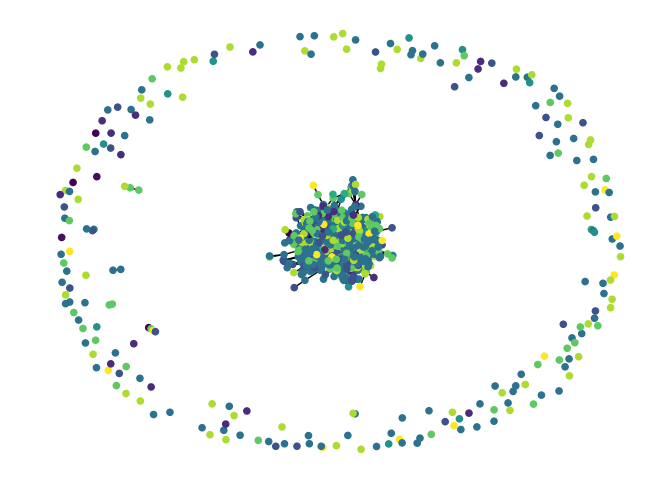

In [21]:
nx.draw(social_graph, cmap=plt.get_cmap('viridis'), node_color=values, node_size=20,with_labels=False, font_color='white')
plt.show()


Below is a recipe for visualizing and performing summary stats, modified from NetworkX documentation.

Some highlights:
* #A This command creates a distinct graph object from the  largest connected component of a given graph. In our example there is only one connected component, so the way this command is programmed is a bit of overkill.
* #B Determines how exactly the nodes and edges will be positioned in the visualization. NetworkX includes a few algorithms to choose from. Spring Layout follows an algorithm that models edges as springs, and nodes as masses that repel one another.
* #C Draws the nodes according to the layout given in the previous line. The draw_network_nodes method has a few input parameters, including the node_side parameter, which adjusts the size of the nodes in the visualization.
* #D Draws the edges according to the layout given above. Like the draw_network_nodes method, this method has multiple ways to specify the appearance of the nodes. The alpha parameter specifies the transparency of the edges.
* #E Graph objects in NetworkX have various methods and attributes. In this line, we use the degree method to generate an iterable of nodes with their respective degrees. This is nested in a sorted comprehension whose output is a list of degrees sorted highest to lowest.
* #F We plot the list generated in #E
* #G We plot a histogram of the number of degrees of the nodes of the graph. Numpy’s unique method (with the return_counts parameter) generates two lists: the nodes’ degrees, and their respective counts.

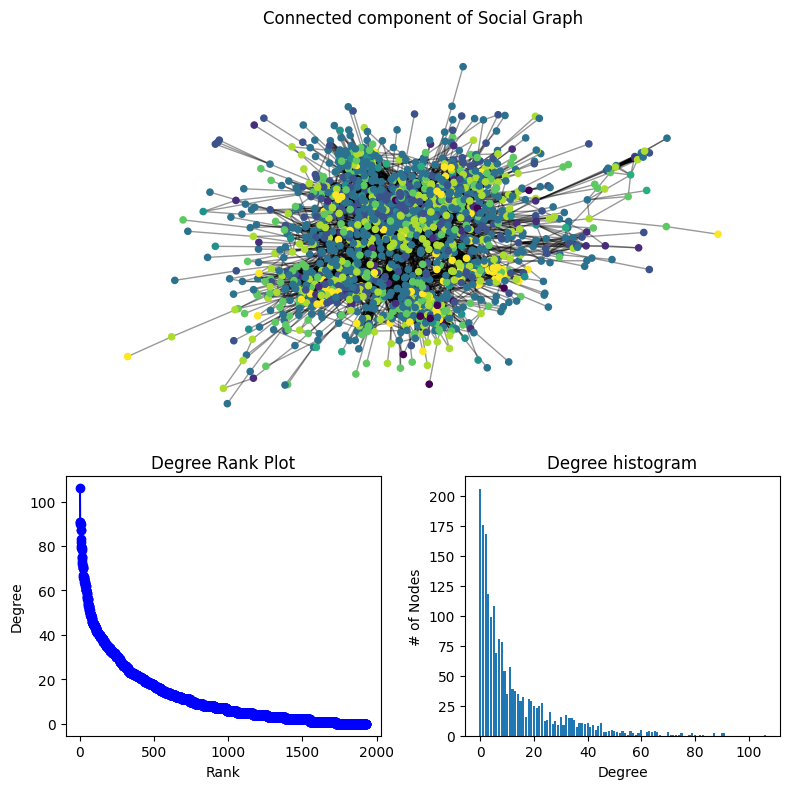

In [22]:


fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])

Gcc = social_graph.subgraph(sorted(nx.connected_components(social_graph), key=len, reverse=True)[0])  #A

groups2 = set(nx.get_node_attributes(Gcc,'position_type').values())
nx.get_node_attributes(Gcc,'position_type')
mapping2 = dict(zip(sorted(groups2),count()))
values2 = [mapping2[attribute_dict[node]['position_type']] for node in Gcc.nodes()]


pos = nx.spring_layout(Gcc, seed=10396953)  #B
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=values2) #C
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4) #D
ax0.set_title("Connected component of Social Graph")
ax0.set_axis_off()

degree_sequence = sorted([d for n, d in social_graph.degree()], reverse=True) #E

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o") #F
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True)) #G
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


The number of nodes and edges in our large connected component.

In [23]:
Gcc.number_of_edges(), Gcc.number_of_nodes()


(12222, 1698)

A (sparse) adjacency matrix of our entire social graph

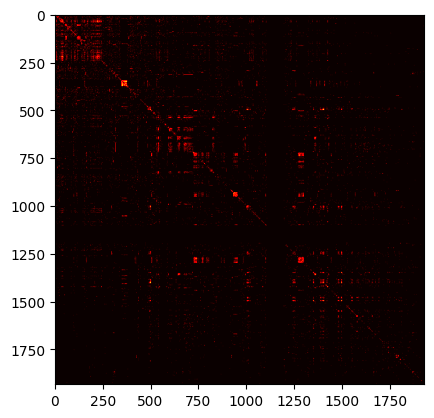

In [25]:
plt.imshow(nx.to_numpy_array(social_graph), aspect='equal',cmap='hot')


V. Preprocessing with Pytorch Geometric

Below, we show a few methods to loading data into pytorch geometric for training:



*   Create directly from a NetworkX graph object
*   Using raw files.
*   Using Dataset classes with raw files
*   Using Data objects to directly create a dataloader without the Dataset class





In [26]:
! python -c "import torch; print(torch.__version__)"

2.0.1+cu118


In [27]:
! python -c "import torch; print(torch.version.cuda)"

11.8


In [30]:
# Install Pytorch Geometric
# Use the information above to fill in the first and second pip lines

# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [33]:
import torch

from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
# from torch_geometric import utils
from torch_geometric.utils.convert import to_networkx, from_networkx


Case A: Create PyG data object using NetworkX object


In [35]:

data = from_networkx(Gcc)


Case B: Create PyG data object using raw files


In [36]:

social_graph = nx.read_adjlist('adjacency_list_candidates.txt')  #A

list_of_nodes = list(set(list(social_graph))) #B
indices_of_nodes = [list_of_nodes.index(x) for x in list_of_nodes]  #C

node_to_index = dict(zip(list_of_nodes, indices_of_nodes))  #D
index_to_node = dict(zip(indices_of_nodes, list_of_nodes))

list_edges = nx.convert.to_edgelist(social_graph)  #E
list_edges = list(list_edges)
named_edge_list_0 = [x[0] for x in list_edges] #F
named_edge_list_1 = [x[1] for x in list_edges]

indexed_edge_list_0 = [node_to_index[x] for x in named_edge_list_0]  #G
indexed_edge_list_1 = [node_to_index[x] for x in named_edge_list_1]

x = torch.FloatTensor([[1] for x in range(len(list_of_nodes))])#  [[] for x in xrange(n)]  #H
y = torch.FloatTensor([1]*974 + [0]*973) #I
y = y.long()

edge_index = torch.tensor([indexed_edge_list_0, indexed_edge_list_1])  #J

train_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8) #K
train_mask[:int(0.8 * len(list_of_nodes))] = 1 #train only on the 80% nodes
test_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8) #test on 20 % nodes
test_mask[- int(0.2 * len(list_of_nodes)):] = 1
train_mask = train_mask.bool()
test_mask = test_mask.bool()

data = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, test_mask=test_mask)  #L


Case C: Create PyG dataset object using custom class and input files


In [37]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):  #A
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self): #B
        return []

    @property
    def processed_file_names(self): #C
        return ['../test.dataset']

    def download(self): #D
        # Download to `self.raw_dir`.
        pass

    def process(self): #E
        # Read data into `Data` list.
        data_list = []

        eg = nx.read_edgelist('edge_list2.txt')

        list_of_nodes = list(set(list(eg)))
        indices_of_nodes = [list_of_nodes.index(x) for x in list_of_nodes]

        node_to_index = dict(zip(list_of_nodes, indices_of_nodes))
        index_to_node = dict(zip(indices_of_nodes, list_of_nodes))

        list_edges = nx.convert.to_edgelist(eg)
        list_edges = list(list_edges)
        named_edge_list_0 = [x[0] for x in list_edges]
        named_edge_list_1 = [x[1] for x in list_edges]

        indexed_edge_list_0 = [node_to_index[x] for x in named_edge_list_0]
        indexed_edge_list_1 = [node_to_index[x] for x in named_edge_list_1]

        x = torch.FloatTensor([[1] for x in range(len(list_of_nodes))])#  [[] for x in xrange(n)]
        y = torch.FloatTensor([1]*974 + [0]*973)
        y = y.long()

        edge_index = torch.tensor([indexed_edge_list_0, indexed_edge_list_1])

        train_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8)
        train_mask[:int(0.8 * len(list_of_nodes))] = 1 #train only on the 80% nodes
        test_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8) #test on 20 % nodes
        test_mask[- int(0.2 * len(list_of_nodes)):] = 1

        train_mask = train_mask.bool()

        test_mask = test_mask.bool()

        data_example = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, test_mask=test_mask) #F

        data_list.append(data_example) #G

        data, slices = self.collate(data_list)  #H
        torch.save((data, slices), self.processed_paths[0])  #I

Case D: Create PyG data objects for use in dataloader without use of a dataset object


In [38]:

from torch_geometric.data import Data, DataLoader

# data_list = [Data(...), ..., Data(...)]
# We'll use the data object from case B
data_list = [data]
loader = DataLoader(data_list, batch_size=32)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
